# 16-bit layers assignment for accuracy increase

In this notebook we'll go over checking the accuracy of a model using the Hailo Model Zoo, how to find the layers that are most likely to have improved accuracy when applying 16-bit conversion and how to apply the 16-bit in a way that will be most efficient considering the accuracy-FPS tradeoff.

The use case is Yolov8s_pose model from the Hailo Model Zoo, which have a relatively large accuracy drop when comparing the Native accuracy with the quantized model one - the loss is relatively significant - 59.2 for native compared to 56 for the quantized model.

##### NOTE: #####
To run this notebook, you need either to be inside of a Hailo Suite docker or a Hailo Model Zoo docker. 
You may use this notebook outside of the above mentioned dockers, but you'll need to have your own `.tfrecord` file and relevant `.json` files for the optimization step and accuracy check.

#### IMPORTANT NOTE: ####
It is highly recommended to use a GPU for both optimization and evaluation (accuracy check). You may use a CPU, but it will be very slow compared to the use of a GPU.

In [ ]:
model_name = 'yolov8s_pose'

## Comparing Native vs Quantized results using the Hailo Model Zoo

First, create the optimized & quantized HAR file of the model using the Hailo Model Zoo CLI tool or the Hailo Dataflow Compiler tool. The Dataflow Compiler commands are commented out in case you want to use it instead. To use the Dataflow Compiler, you can either use the CLI tool or the actual Python API as instructed in the Dataflow Compiler user guide.

You can use your own calibration set or download the relevant default calibration set for the model using the Hailo Model Zoo as instructed in the Hailo Model Zoo user guide:

First we create the parsed HAR from the Hailo Model Zoo:

In [ ]:
# Get the parsed HAR
!hailomz parse {model_name}

Then, we create the quantized HAR. 

##### Notice: ##### 
If you use the hailomz command, the quantized HAR name will be the same as the parsed one, so it will run over the parsed one. Since we need the parsed HAR later in this tutorial, if you choose to use hailomz and not hailo, use the cp\mv Linux command to create a copy with a different name for the parsed HAR.

Also, the name of the generated quantized HAR from the Hailo Model Zoo command is similar to the name of the automatically generated parsed HAR name. So, it's strongly recommended to change the name of the quantized HAR to be MODEL_NAME_quantized.har.

For those who use the Dataflow compiler tool, it will happen automatically.

In [ ]:
# Create a quantized model based on the default YAML & model script files of that model
!hailomz optimize {model_name}.har --calib-path /path/to/calibration/imgs/dir/ 

# !hailo optimize {model_name}.har --calib-set-path /path/to/calib/set/file.npy --model-script /path/to/model/script/file.alls

After optimization is done and you have your quantized model, evaluate the model's accuracy for the native and quantized models. The bottom print to the screen will sum all the information acheived from the evaluation and give the average accuracy of the model.

Native model evaluation:

In [ ]:
# mAP eval for native
!hailomz eval {model_name} --har {model_name}_quantized.har --performance

Quantized model evaluation:

In [ ]:
# mAP eval for quantized
!hailomz eval {model_name} --har {model_name}_quantized.har --­­target emulator --performance

You can see there is a difference in the accuracy measured, which makes sense because we convert the weights and activations representation from float32 to uint8, so there will be some loss. With that saying, as described in the begnning of the notebook, the accuracy degradation here is relatively significant 

## Layer Analysis

If all layers are supported, you can have the model fully in 16-bit to improve accuracy, but it will come with a very big FPS degradation. For example, the yolov8s_pose compiled by the Hailo Model Zoo runs on 104 FPS, while the full 16-bit model runs on 14 FPS. So, you need to pick the best layers that will raise the accuracy the most without hurting the FPS too much.

To find the best candidate layers for 16-bit accuracy raise, first run the Layer-Analysis tool:

In [ ]:
# Run noise-analysis
!hailo analyze-noise {model_name}_quantized.har --analyze-mode advanced --data-path /path/to/calib/set/file.npy  --work-dir .

Run the Hailo Profiler on the quantized model. After running the Layer-Analysis tool, the quantized HAR will hold the information from it:

In [ ]:
!hailo profiler {model_name}_quantized.har --no-browser

Now, in the profiler report generated, go to the Accuracy tab. Under "Layer information", look for layers that have a relatively wide scatter plot. 

For example, these layers:
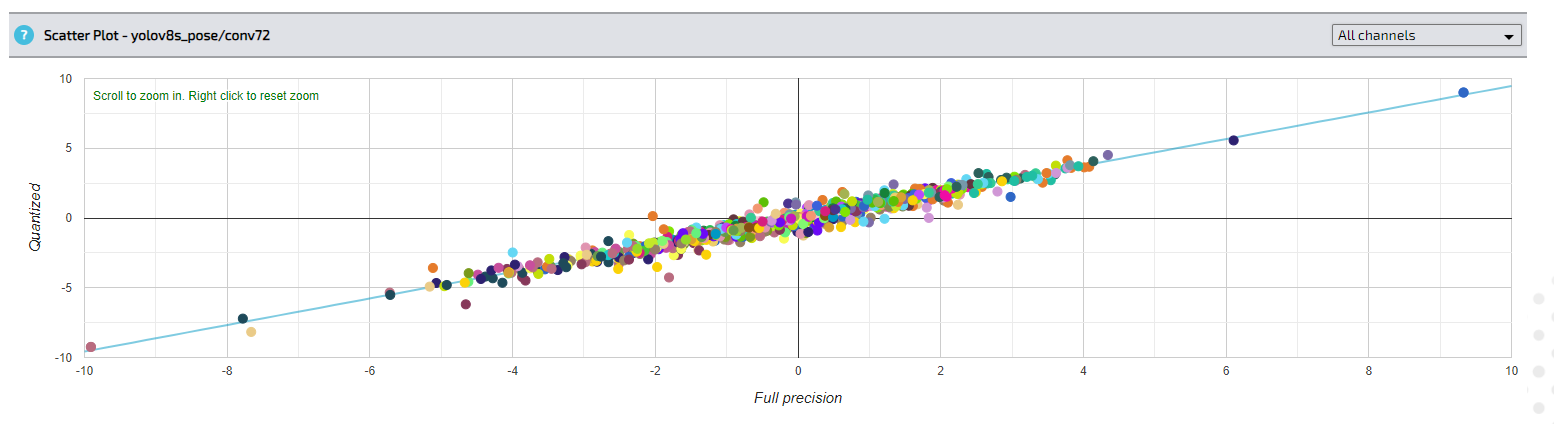
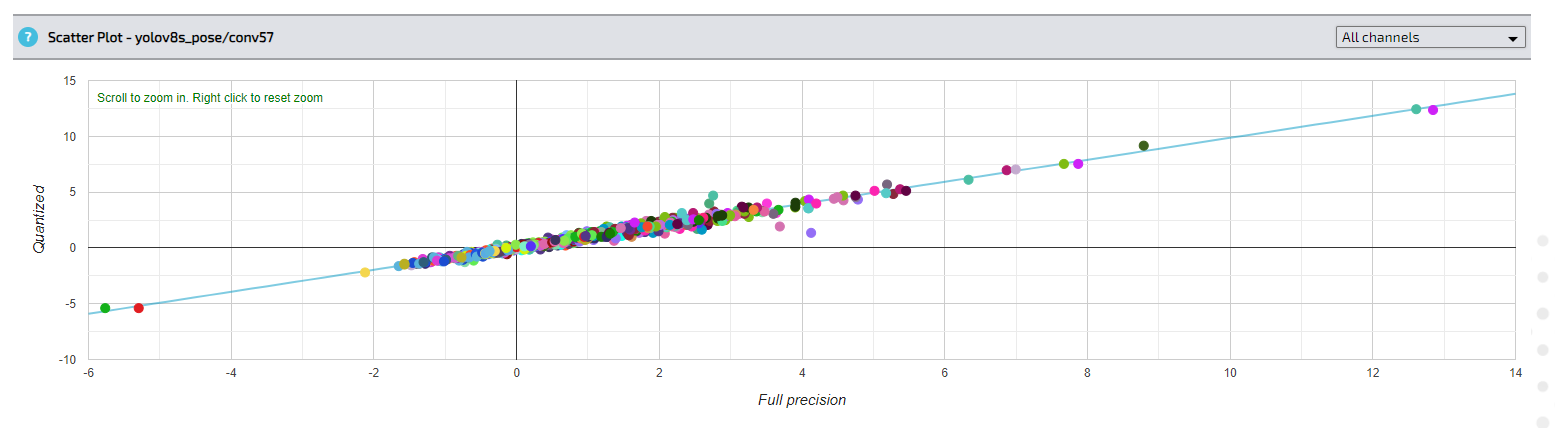
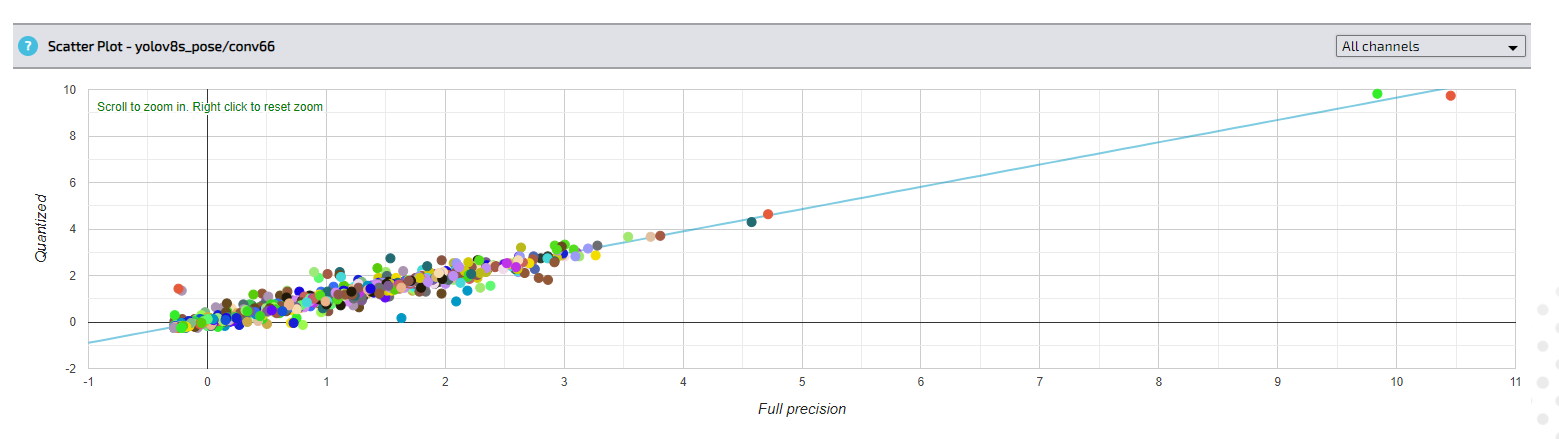

Are good candidates to apply 16-bit to in order to raise accuracy.

##### NOTE: ##### 
Layers at the end of the model will more likely to be sensetive to 16-bit conversion, so as a rule of thumb it's best to apply 16-bit to them first.  

## Applying 16-bit layers with caution

The reason we pick specifically layers with wide scatter for the 16-bit conversion, is pretty logical - for the native model we have data that is represented in float32, meaning 32-bit of data. When quantized, it's reduced to 8-bit. So, the wider the range of values is for a layer, more distant values will be sorted into the same "bin" of the qunatized weights, which will cause distortion in the output data.

The 16-bit doesn't fix this completely, but it improves it, sometimes very much.

After listing all the layers that seems relevant for 16-bit, we need to pick those who will have the most effect on accuracy and least effect on FPS.

Let's assume for the matter at hand that these are the layers we marked as most likely to raise accuracy with 16-bit according to their scatter plot:

conv4, conv5, conv42, conv43, conv45, conv56, conv57, conv59, conv66, conv69, conv70, conv72

### Visualization helps us narrow the number of layer to convert to 16-bit

Visualize the model to see where the layers are located in the graph:

In [ ]:
!hailo visualizer {model_name}.har --no-browser
SVG('yolov8s_pose.svg')

We see that in the model, layers conv42, conv43, conv45, conv56, conv57, conv59, conv66, conv69, conv70, conv72 are all near outputs of the model, while conv4, conv5 are close to the beginning.

Conv4 & conv5 are in the middle of this block:
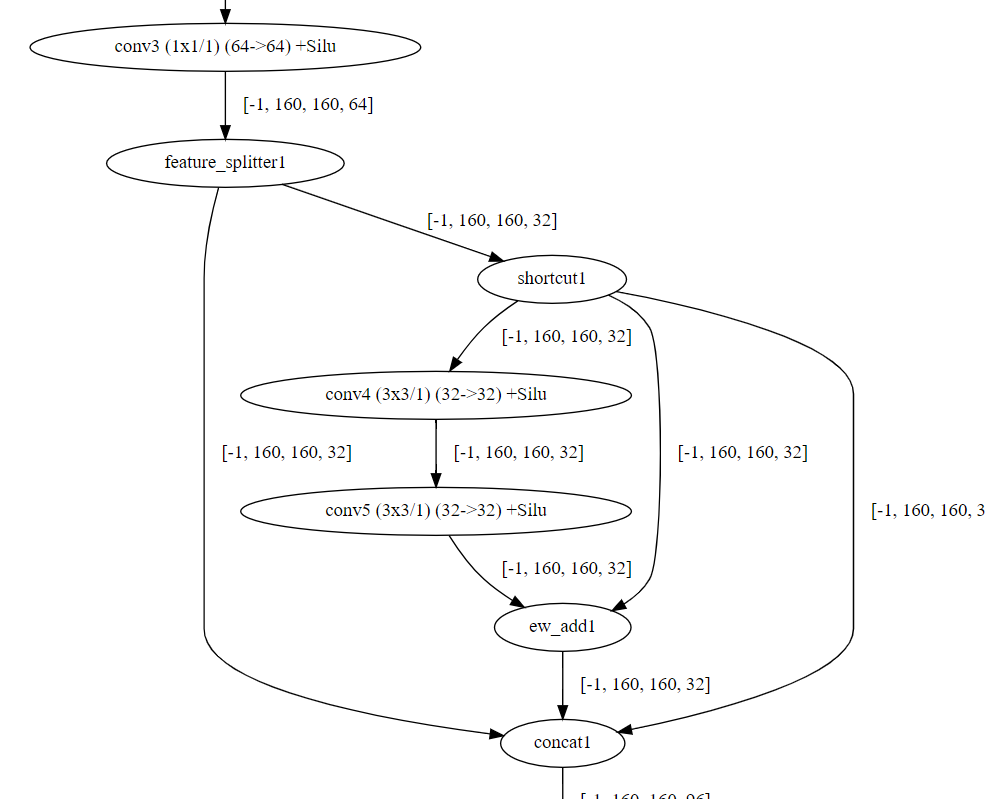

Since feature_splitter, concat and shortcut layers can only output the format they get as an input (8-->8 or 16-->16, but not 8-->16 or 16-->8), we need to convert the whole block + conv3 and conv6 to be 16-bit. 

If we look at conv66:
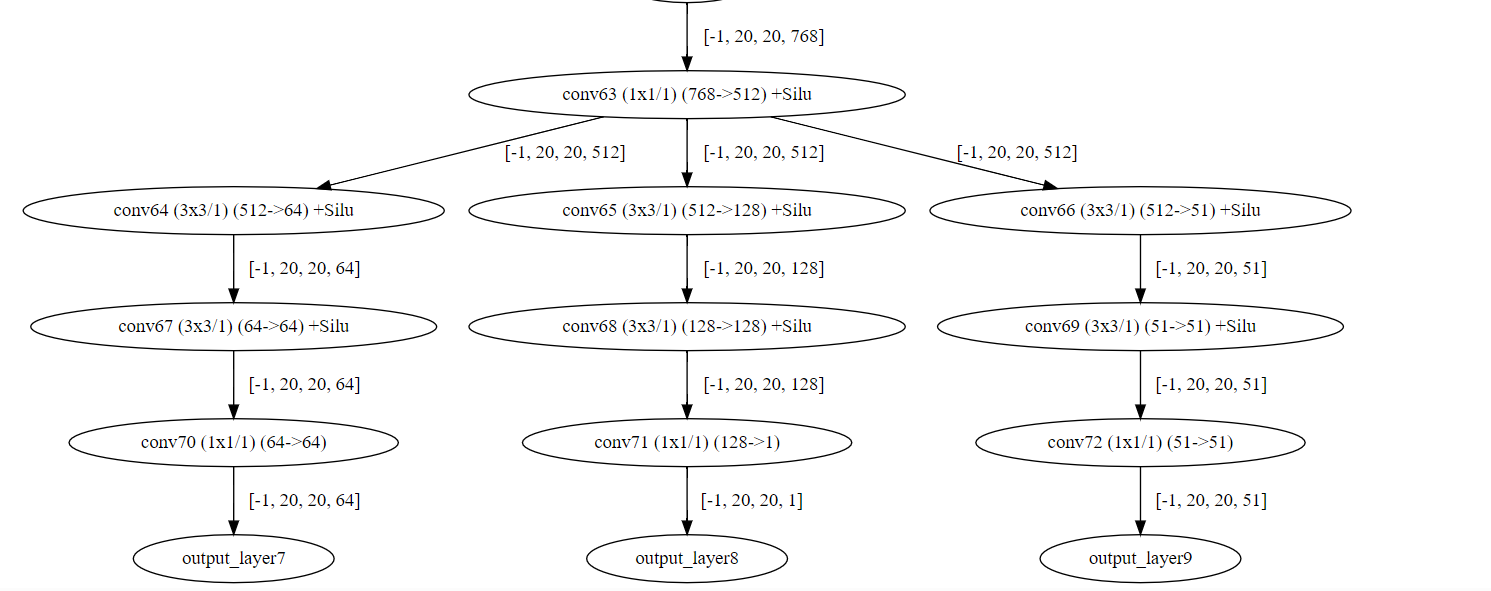

We can see that if we want it to be 16-bit, we need conv63 to output 16-bit, which means that also conv64 and conv65 will be 16-bit, even though it doesn't seems that these layers in 16-bit will have a great effect (if at all) on accuracy.

If we run optimization with 16-bit to all the above mentioned layers and run eval, we'll get 58.253 mAP. An improvement of more than 2 mAP points. Good right?

But when we compile the model and run inference, we'll get 59 FPS, compared to the 104 FPS we get from the original model. That's a 44% degradation, which can be quite a lot if there's a performance target.

So, let's assume we have a FPS target and the cost of applying 16-bit to all the layers we mentioned is too much. So, we'll leave both start layers (conv4 & conv5) and conv66 in 8-bit.

We are left with conv42, conv43, conv45, conv56, conv57, conv59, conv69, conv70, conv72 to be converted to 16-bit.

## Re-running optimization to apply the 16-bit conversion 

Now, create the model script with the relevant 16-bit layers (along with the default Hailo Model Zoo commands):

In [ ]:
model_script_commands = [
'normalization1 = normalization([0.0, 0.0, 0.0], [255.0, 255.0, 255.0])\n',
'change_output_activation(conv71, sigmoid)\n',
'change_output_activation(conv58, sigmoid)\n',
'change_output_activation(conv44, sigmoid)\n',
'pre_quantization_optimization(equalization, policy=disabled)\n',
'quantization_param(output_layer3, precision_mode=a16_w16)\n',
'quantization_param(output_layer6, precision_mode=a16_w16)\n',
'quantization_param(output_layer9, precision_mode=a16_w16)\n',
'post_quantization_optimization(finetune, policy=enabled, learning_rate=0.00015)\n',

'quantization_param(conv66, precision_mode=a8_w8_a16)\n',
'quantization_param(conv69, precision_mode=a16_w16)\n',
'quantization_param(conv72, precision_mode=a16_w16)\n',
'quantization_param(conv67, precision_mode=a8_w8_a16)\n',
'quantization_param(conv70, precision_mode=a16_w16)\n',

'quantization_param(conv54, precision_mode=a8_w8_a16)\n',
'quantization_param(conv57, precision_mode=a16_w16)\n',
'quantization_param(conv53, precision_mode=a8_w8_a16)\n',
'quantization_param(conv56, precision_mode=a16_w16)\n',
'quantization_param(conv59, precision_mode=a16_w16)\n',

'quantization_param(conv39, precision_mode=a8_w8_a16)\n',
'quantization_param(conv40, precision_mode=a8_w8_a16)\n',
'quantization_param(conv43, precision_mode=a16_w16)\n',
'quantization_param(conv42, precision_mode=a16_w16)\n',
'quantization_param(conv45, precision_mode=a16_w16)\n'
]

Save them to an .alls file to use in the optimization step:

In [ ]:
open('model_script.alls','w').writelines(model_script_commands)

And run optimization & quantization with the updated model script:

In [ ]:
# Optimize and quantize with the new 16-bit layers
!hailomz optimize {model_name} --har {model_name}.har --­­calib-­path /path/to/calibration/imgs/dir/ --model-script /path/to/model/script/file.alls

# !hailo optimize {model_name}.har --calib-set-path /path/to/calib/set/file.npy --model-script /path/to/model/script/file.alls

Rename it with "_quantized" suffix (in case you used the hailomz command):

In [ ]:
!mv {model_name}.har {model_name}_quantized.har

Now run evaluation again:

In [ ]:
# mAP eval for quantized with 16-bit layers
!hailomz eval {model_name} --har {model_name}_quantized.har --­­target emulator --performance

We can now see that the accuracy improved from 56 to 57.4.

But, we still need to see what's the degradation in FPS is.

## Compilation and FPS measurment

Run compilation either with the Hailo Model Zoo or the Dataflow compiler:

In [ ]:
!hailomz compile {model_name} --har {model_name}_quantized.har

# !hailo compiler {model_name}_quantized.har

And run inference using the HailoRT CLI tool:

In [ ]:
!hailortcli run {model_name}.hef

And we can see that the FPS drop was from 104 too 100. Only 4 FPS, which is a mere 3% degradation in FPS, when we got in return 1.4 mAP points of accuracy. 